<a href="https://colab.research.google.com/github/LLAlex85/CPP/blob/master/plantas_reloaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plantas Tipo y Estado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip './drive/MyDrive/color.zip'

Streaming output truncated to the last 5000 lines.
  inflating: color/soybean___healthy/b2eea7a6-30bf-4db8-b7e2-d33af7a0be50___RS_HL 3995.JPG  
  inflating: __MACOSX/color/soybean___healthy/._b2eea7a6-30bf-4db8-b7e2-d33af7a0be50___RS_HL 3995.JPG  
  inflating: color/soybean___healthy/66ef3428-ed7e-45b2-974c-8fb649f0e359___RS_HL 5748.JPG  
  inflating: __MACOSX/color/soybean___healthy/._66ef3428-ed7e-45b2-974c-8fb649f0e359___RS_HL 5748.JPG  
  inflating: color/soybean___healthy/4dd034e3-8e20-47bb-9ff1-cc7e8a10999c___RS_HL 3399.JPG  
  inflating: __MACOSX/color/soybean___healthy/._4dd034e3-8e20-47bb-9ff1-cc7e8a10999c___RS_HL 3399.JPG  
  inflating: color/soybean___healthy/a5e9bbda-c74e-4059-ba12-7b2dafb15338___RS_HL 7091.JPG  
  inflating: __MACOSX/color/soybean___healthy/._a5e9bbda-c74e-4059-ba12-7b2dafb15338___RS_HL 7091.JPG  
  inflating: color/soybean___healthy/29040ffb-9de2-4d78-b5c7-ecb504c4805f___RS_HL 4536.JPG  
  inflating: __MACOSX/color/soybean___healthy/._29040ffb-9de2-4d78-b

In [ ]:
import os
import cv2
import numpy as np
from imutils import paths
import shutil
import re
import gc
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Categorías y/o etiquetas están determinadas por el nombre del folder
folders_list = os.listdir("./color/")
folders_lower = [str.lower(f) for f in folders_list]    

Observa cuántos tipos de plantas existen

In [ ]:
fruit_folder = []  

#Verifica la cantidad de frutas/plantas diferentes
for folder_name, folder_lower in zip(folders_list, folders_lower):

    if os.path.isdir("./color/" + folder_name) :
        fruit_name = folder_lower.split('_')[0]
        
        if not ( fruit_name in fruit_folder ):
            fruit_folder.append(fruit_name)
        
print(f"Hay {len(fruit_folder)} tipos diferentes")
print(fruit_folder)

#Crea Test y Train folder
test_path = "./Test/"
train_path = "./Train"

Hay 14 tipos diferentes
['tomato', 'apple', 'strawberry', 'grape', 'pepper,', 'peach', 'squash', 'blueberry', 'raspberry', 'cherry', 'corn', 'orange', 'soybean', 'potato']


Crea Folders para Prueba y Entrenamiento

In [ ]:

healthy = "_healthy"


if not os.path.exists(test_path):
    os.makedirs(test_path)
if not os.path.exists(train_path):
    os.makedirs(train_path)

for folder in folders_list:

    f = folder.lower()
    fruit = f.split("_")[0]
    new_folder = os.path.sep.join([test_path, fruit + healthy if "healthy" in f else fruit ])
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    new_folder = os.path.sep.join([train_path, fruit + healthy if "healthy" in f else fruit])    
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

Separa y Copia imágenes de prueba y entrenamiento

In [ ]:
train_split = 0.9
val_split = 0.1

for f in folders_list:
    img_paths = list(paths.list_images("./color/"+f))
    random.seed(30)
    random.shuffle(img_paths)

    s = int(len(img_paths)*train_split)
    train_img_paths = img_paths[:s]   # listado de rutas de imágenes para entrenamiento
    test_img_paths = img_paths[s:]    # listado de rutas de imágenes para pruebas
    
    fruit_name = f.split('_')[0].lower()

    if "healthy" in f:
        for tr_image in train_img_paths:
            shutil.copy2(tr_image, os.path.sep.join([train_path, fruit_name + "_healthy"]))
        for t_image in test_img_paths:
            shutil.copy2(t_image, os.path.sep.join([test_path, fruit_name + "_healthy"]))
    else:
        for tr_image in train_img_paths:
            shutil.copy2(tr_image, os.path.sep.join([train_path, fruit_name]))
        for t_image in test_img_paths:
            shutil.copy2(t_image, os.path.sep.join([test_path, fruit_name]))


In [ ]:
!rm -rf ./Test/.ds
!rm -rf ./Train/.ds

Crea un Generador de Imágenes. Este normalizará las imágenes y creará un subset del 10%. 

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1)

path=train_path

#test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        path,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        color_mode='rgb'
        )

validation_generator = train_datagen.flow_from_directory(
        path,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        color_mode='rgb')


test_datagen = ImageDataGenerator(
        rescale=1./255)

#test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        color_mode='rgb'
        )

Found 43980 images belonging to 23 classes.
Found 4877 images belonging to 23 classes.
Found 5448 images belonging to 23 classes.


Obtiene las dimensiones de los datos

In [ ]:
X, Y =next(train_generator)
print(X.shape, Y.shape)

Xv, Yv =next(validation_generator)
print(Xv.shape, Yv.shape)

(32, 64, 64, 3) (32, 23)
(32, 64, 64, 3) (32, 23)


Crea Modelo con capas Convolucioneales. Este modelo está basado en VGG. 

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow as tf

shape = X[0].shape

print(shape)

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=1, activation='relu', input_shape=shape),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(23, activation='softmax')
    
])

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights('./drive/MyDrive/model_weights_reloaded_plants')

(64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                        

In [ ]:
#history = model.fit(img_train, labels_train, validation_split = 0.10, epochs = 15, batch_size = 50, verbose = 1)
#history = model.fit_generator(        train_generator,
        #steps_per_epoch=2000,
#        epochs=1,
#        validation_data=validation_generator,
        #validation_steps=800)
#    )


checkpoint_filepath='./drive/MyDrive/model_weights_reloaded_plants'
my_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

my_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1, patience=3)

modelX = model.fit(train_generator, epochs = 35, validation_data = validation_generator, callbacks=[my_checkpoint_callback, my_earlystopping_callback])


Epoch 1/35
1375/1375 [==============================] - 152s 111ms/step - loss: 0.2401 - accuracy: 0.9215 - val_loss: 33.7710 - val_accuracy: 0.7757
Epoch 2/35
1375/1375 [==============================] - 158s 115ms/step - loss: 0.2343 - accuracy: 0.9257 - val_loss: 5.9064 - val_accuracy: 0.4642
Epoch 3/35
1375/1375 [==============================] - 151s 110ms/step - loss: 0.2286 - accuracy: 0.9258 - val_loss: 4.0464 - val_accuracy: 0.8563
Epoch 4/35
1375/1375 [==============================] - 160s 116ms/step - loss: 0.2147 - accuracy: 0.9300 - val_loss: 0.2085 - val_accuracy: 0.9323


In [ ]:
#model.load_weights(filepath='./model_weights.h5')
model.save_weights(filepath='./drive/MyDrive/model_weights_reloaded_plants_model_weights.h5')

Grafica el cambio de certeza durante el entrenamiento

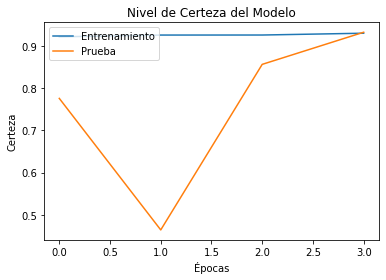

In [ ]:
import matplotlib.pyplot as plt

plt.plot(modelX.history['accuracy'])
plt.plot(modelX.history['val_accuracy'])
plt.title('Nivel de Certeza del Modelo')
plt.ylabel('Certeza')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

Funciones de ayuda para probar el modelo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def getImage(path, x =1.0, y=1.0, flatten=False):
  img_bgr=cv2.imread(path)
  
 # plt.imshow(img, origin=None)
 # plt.axis('off')
 # plt.title("Imagen de Prueba")
 # print(img.shape)
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)
  img=cv2.resize(img, None, fx=x, fy=y)
  #Podemos agregar operaciones de preprocesamiento
  img = img* (1/255.0)
  
  if flatten is True:
    img=img.flatten()

  return img

#Definir una Función para Pruebas
def test_the_model(model, image_path):
  img = getImage(image_path, 0.25, 0.25)
  
  shape = img.shape
  img = img.reshape(1, shape[0], shape[1], shape[2])

  prediction = model.predict(img)
  prediction = np.argmax(prediction)
  
  labels = (train_generator.class_indices)
  labels = dict((v,str.lower(k)) for k,v in labels.items())
  
  return labels[prediction]

Evalua los datos del set de validación usando el generador

In [ ]:
score = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[0], score[1]*100))

153/153 [==============================] - 13s 88ms/step - loss: 0.2152 - accuracy: 0.9311
evaluate loss: 93.11%


In [ ]:
score = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[0], score[1]*100))

171/171 [==============================] - 11s 63ms/step - loss: 14.0020 - accuracy: 0.9394
evaluate loss: 93.94%


In [ ]:
#Evalua modelo de forma arcaica
hits = 0
for f in test_generator.filenames:  
    name = './Test/'+ f
    if test_the_model(model, name) in str.lower(name):
        hits = hits + 1
print(f"Cantidad de Imágenes que coinciden {hits}")
    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Cantidad de Imágenes que coinciden 5149


In [ ]:
def obtieneTipoSalud(model, name):
    clase = test_the_model(model, name)
    result = []
    
    result.append(clase.split('_')[0])
    if "healthy" in clase:
        result.append("healthy")
    else:
        result.append("ill")
        
    return result

Obtiene predicción por Imagen de tipo de fruta y si está enferma o no.

In [ ]:
print(obtieneTipoSalud(model, './color/Peach___Bacterial_spot/0090cfcf-caf7-424d-b19c-533e09c6d24c___Rutg._Bact.S 2388.JPG'))

1/1 [==============================] - 0s 25ms/step
['peach', 'ill']
